In [3]:
'''
統計假設檢定
'''
# 二項式隨機變數
# 以常態分佈做近似的結果
def normal_approximation_to_binomial(n, p):
    '''
    求出 Binomial(n, p) 相應的平均值 mu 和標準差 sigma
    '''
    mu = p * n
    sigma = math.sqrt(p* (1 - p) * n)
    return mu, sigma

##############################################

# 之前定義的函式
from matplotlib import pyplot as plt
import math

def normal_cdf(x, mu=0, sigma=1):
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

##############################################


'''
用 normal_cdf 計算出其值落在特定區間之內 (或之外) 的機率
'''
# normal_cdf 代表的是變數落在某個門檻值以下的機率
normal_probability_below = normal_cdf

# 若不在門檻值以下，就表示在門檻值以上
def normal_probability_above(lo, mu=0, sigma=1):
    return 1 - normal_cdf(lo, mu, sigma)

# 若低於 hi 且不低於 lo，就表示落在區間之內
def normal_probability_between(lo, hi, mu=0, sigma=1):
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

# 若不在區間之內，就表示落在區間之外
def normal_probability_outside(lo, hi, mu=0, sigma=1):
    return 1 - normal_probability_between(lo, hi, mu, sigma)

In [19]:
'''
推算「非尾區間」
'''
##############################################

# 之前定義的函式
def inverse_normal_cdf(probability, mu=0, sigma=1, tolerance=0.00001):
    '''
    用二元搜尋法逆向求出近似值
    '''
    # 如果不是標準常態分佈，就先轉換成標轉常態分佈
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(probability, tolerance)

##############################################

def normal_upper_bound(probability, mu=0, sigma=1):
    '''
    送回一個 z值，使得 P(Z <= z) = 某個機率值
    '''
    return inverse_normal_cdf(probability, mu, sigma)

def normal_lower_bound(probability, mu=0, sigma=1):
    '''
    送回一個 z值，使得 P(Z >= z) = 某個機率值
    '''
    return inverse_normal_cdf(probability, mu, sigma)

def normal_two_sided_bounds(probability, mu=0, sigma=1):
    '''
    送回一個 (以平均值為中心的) 對稱邊界
    其中所涵蓋的區域，正好對應指定的機率值
    '''
    tail_probability = ( 1 - probability) / 2
    
    # 高於上邊界的機率，應該恰等於 tail_probability
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)
    
    # 低於下邊界的機率，也應該等於 tail_probability
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)
    
    return lower_bound, upper_bound

# if "The coin is fair", mean and sd are 500, 15.8 distribution of X
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
print("mu_0 : %.1f" %  mu_0, "\n" + "sigma_0 : %.1f" % sigma_0)


# 顯著性 (significance)
# 會犯下 type 1 error 的機率

# if X in the outside bound, we can reject H0 hypothesis
# print("normal_two_sided_bounds :", normal_two_sided_bounds(0.95, mu_0, sigma_0))

mu_0 : 500.0 
sigma_0 : 15.8


In [26]:
'''
檢定力 (power)
    不犯下 type 2 error 的機率
'''
# 根據 p = 0.5 的零假設，所得到的 95%邊界
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)

# 實際上 p = 0.55，根據此情況，計算出真實的 mu 與 sigma
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)

# 第二類型錯誤表示應否決而未否決零假設
# x 若還是落在零假設區間內，則認為假設沒問題，而犯下型二錯誤
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1 - type_2_probability       # 0.887 is type 2 error
# print("power : %.3d" % power)

# 單邊檢定 one-sided test
hi = normal_upper_bound(0.95, mu_0, sigma_0)
# 截點值為 526 (< 531，有 5%的可能性全都在 X比 500大很多的上尾部那邊)

type_2_probability = normal_probability_bellow(hi, mu_1, sigma_1)
power = 1 - type_2_probability     # 0.936
print("power : %.3d" % power)

RecursionError: maximum recursion depth exceeded in comparison

In [34]:
# P-value
# use two-sided test to test the coin whether fair
def two_sided_p_value(x, mu=0, sigma=1):
    if x >= mu:
        # 如果 x 大於平均值，就計算大於 x的上尾部
        return 2 * normal_probability_above(x, mu, sigma)
    else:
        # 如果 x 小於平均值，就計算小於 x的下尾部
        return 2 * normal_probability_below(x, mu, sigma)
    
# if the test results are 500 times of heads, we'll calculate
print("two_sided_p_value : %.3f" % two_sided_p_value(529.5, mu_0, sigma_0))     # 0.062


# use the huge data to support an evidence
import random
extreme_value_count = 0
for _ in range(100000):
    num_heads = sum(1 if random.random() < 0.5 else 0         # 每丟擲 1000次硬幣，
                   for _ in range(1000))                      # 就計算一次丟出正面的次數
    if num_heads >= 530 or num_heads <= 470:                  # 再計算下一次
        extreme_value_count += 1                              # 其中次數很極端的發生機率
        
print("extreme_value_count : %.3f" % (extreme_value_count / 100000 ))     # 0.062
print("---------------")


# if the test results are 532 times of heads, the p-value is below
print("if n = 532, two_sided_p_value : %.4f" % two_sided_p_value(531.5, mu_0, sigma_0))   # 0.0463

upper_p_value = normal_probability_above
lower_p_value = normal_probability_below
print("if n = 525, upper_p_value : %.3f" % upper_p_value(524.5, mu_0, sigma_0))     # 0.061
print("if n = 527, upper_p_value : %.3f" % upper_p_value(526.5, mu_0, sigma_0))     # 0.047
print("if n = 525, lower_p_value : %.3f" % lower_p_value(526.5, mu_0, sigma_0))     # 0.953
print("if n = 527, lower_p_value : %.3f" % lower_p_value(527.5, mu_0, sigma_0))     # 0.959

two_sided_p_value : 0.062
extreme_value_count : 0.062
---------------
if n = 532, two_sided_p_value : 0.0463
if n = 525, upper_p_value : 0.061
if n = 527, upper_p_value : 0.047
if n = 525, lower_p_value : 0.953
if n = 527, lower_p_value : 0.959


In [41]:
'''
信賴區間 (confidence interval)
'''
import math

# The mean is p, sd is 
p = 0.435
sd = math.sqrt(p * (1 - p) / 1000)                # 0.0157
print("sd : %.4f" % sd)

# the change estimate
p_hat = 525 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)     # 0.0158
print("sigma : %.4f" % sigma)

# if we have 0.95 confidence to believe true value of p between this interval
# print("normal_two_sided_bounds : %.4f" % list(normal_two_sided_bounds(0.95, mu, sigma)))     # [0.4940, 0.5560]

# if we gain is 540 times of heads, we'll calculate
p_hat = 540 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)     # 0.0158
# print("normal_two_sided_bounds of p_hat : %.4f" % list(normal_two_sided_bounds(0.95, mu, sigma)))   # [0.5091, 0.5709]

sd : 0.0157
sigma : 0.0158


In [44]:
'''
P-hacking
    出現誤判而否決掉零假設的情況
'''
import random

def run_experiment():
    '''
    丟擲一個公正的硬幣 1000次，True表示正面，False表示反面
    '''
    return [random.random() < 0.5 for _ in range(1000)]

def reject_fairness(experiment):
    '''
    使用 5% 的顯著程度
    '''
    num_heads = len([flip for flip in experiment if flip])
    return num_heads < 469 or num_heads > 531

random.seed(0)
experiments = [run_experiment() for _ in range(1000)]
num_rejections = len([experiment
                     for experiment in experiments
                     if reject_fairness(experiment)])

print("num_rejections :", num_rejections)       # 46

num_rejections : 46


In [61]:
'''
執行 A/B 測試
'''
def estimated_parameters(N, n):
    p = n / N
    sigma = math.sqrt(p * (1 - p) / N)
    return p, sigma

print("estimated_parameters : ", estimated_parameters(1000, 100))


# p_A as same as p_B
def a_b_test_statistic(N_A, n_A, N_B, n_B):
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B - p_A) / math.sqrt(sigma_A ** 2 + sigma_B **2)

z = a_b_test_statistic(1000, 200, 1000, 180)
print("z : %.3f" % z)

two_sided_p_value(z)
print("two_sided_p_value(z) : %.3f" % two_sided_p_value(z))
print("---------------")

z = a_b_test_statistic(1000, 200, 1000, 150)
two_sided_p_value(z)
print("two_sided_p_value(z) : %.3f" % two_sided_p_value(z))

estimated_parameters :  (0.1, 0.009486832980505138)
z : -1.140
two_sided_p_value(z) : 0.254
---------------
two_sided_p_value(z) : 0.003


B(1,1) : 1.0
B(10,10) : 1.0825088224469029e-06
B(4,16) : 6.449948400412796e-05
B(16,4) : 6.449948400412796e-05
---------------


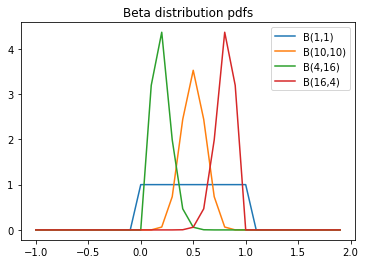

In [114]:
'''
貝氏推論
    把未知參數視為隨機變數
    先驗分布 (prior distribution)，利用觀測數據和貝氏定理進行更新
    後驗分布 (posterior distribution)
'''
from matplotlib import pyplot as plt

# Beta distribution
def B(alpha, beta):
    '''
    已正則化的常數，使總機率為 1
    '''
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)

def beta_pdf(x, alpha, beta):
    if x < 0 or x > 1:          # [0, 1] 之外不給任何權重
        return 0
    return x ** (alpha - 1) * (1 - x ) ** (beta - 1) / B(alpha, beta)

print("B(1,1) :", B(1,1))
print("B(10,10) :", B(10,10))
print("B(4,16) :", B(4,16))
print("B(16,4) :", B(16,4))
print("---------------")

xs = [x / 10.0 for x in range(-10, 20)]
plt.plot(xs, [beta_pdf(x, 1, 1) for x in xs], '-', label='B(1,1)')
plt.plot(xs, [beta_pdf(x, 10, 10) for x in xs], '-', label='B(10,10)')
plt.plot(xs, [beta_pdf(x, 4, 16) for x in xs], '-', label='B(4,16)')
plt.plot(xs, [beta_pdf(x, 16, 4) for x in xs], '-', label='B(16,4)')
plt.legend()
plt.title("Beta distribution pdfs")
plt.show()